# Prepare Dataframes

Import pandas for manipulating data and numpy for some basic utilities. Use `pd.read_excel` to read the xlsx and `sheet_name=None` option to make different sheets accessible with their original names using `dfs['sheet']` syntax

In [1]:
import pandas as pd
import numpy as np
dfs = pd.read_excel("2017_microdata.xlsx", sheet_name=None)

First, set `df` to be the whole relevant dataframe, which is the sheet `2017_microdata`. I will derive other dataframes to work with from here.

In [2]:
df = dfs['2017_microdata']

Define `breach_data` to be the whole dataframe  with rows removed where `salesa` is `"Don't know" or -1`. 

In [3]:
breach_data = df.loc[df['salesa'].isin(["Don't know", -1]) == False]

# Calculate Imputed Values for Categorical Data

Create a new dataframe called `newdf` which is a copy of the column `salesa` from `breach_data`. Then run `np.select` to map each revenue band to an integer which I will use to group and find the average by band to use as an imputed value. (Maybe there is a way to do this all at once?)

In [4]:
impute_df = breach_data[['salesa']].copy()
conditions = [
    (breach_data['salesa'] >= 0) & (breach_data['salesa'] < 50000),
    (breach_data['salesa'] >= 50000) & (breach_data['salesa'] < 100000),
    (breach_data['salesa'] >= 100000) & (breach_data['salesa'] < 500000),
    (breach_data['salesa'] >= 500000) & (breach_data['salesa'] < 2000000),
    (breach_data['salesa'] >= 2000000) & (breach_data['salesa'] < 10000000),
    (breach_data['salesa'] >= 10000000) & (breach_data['salesa'] < 500000000),
    (breach_data['salesa'] >= 50000000)]
choices = ['1', '2', '3', '4', '5', '6','7']
impute_df['revenue_band'] = np.select(conditions, choices, default='0')

Convert `salesa` to float type to avoid pandas giving me a numeric error, then create a new df `imputed_revenue` by grouping by `revenue_band` and taking the mean.

In [5]:
impute_df['salesa'] = impute_df['salesa'].astype(float)
imputed_revenue = impute_df.groupby(impute_df['revenue_band']).mean()

# Dealing with categorical data points

Create a new dataframe, `categorical_breach_data` which contains the rows we ignored because there was not an answer in `salesa`. 

This should be a subset of `df` with all the rows which: 1. Are `Don't know` or `-1` in `salesa` (meaning they are NOT in `breach_data`), 2. Are NOT `Don't know` or `-1` in `salesb`

In [6]:
categorical_breach_data = df.loc[df['salesa'].isin(["Don't know", -1])]   
categorical_breach_data = categorical_breach_data.loc[categorical_breach_data['salesb'].isin(["Don't know", -1])== False]

Convert unused (`Don't know` or `-1`) values in `salesa` to imputed revenue values from previous section.

In [7]:
conditions = [
    (categorical_breach_data['salesb'] == 'Less than £50,000'),
    (categorical_breach_data['salesb'] == '£50,000 to less than £100,000'),
    (categorical_breach_data['salesb'] == '£100,000 to less than £500,000'),
    (categorical_breach_data['salesb'] == '£500,000 to less than £2 million'),
    (categorical_breach_data['salesb'] == '£2 million to less than £10 million'),
    (categorical_breach_data['salesb'] == '£10 million to less than £50 million'),
    (categorical_breach_data['salesb'] == '£50 million or more')
]
choices = list(imputed_revenue['salesa'])
categorical_breach_data['salesa'] = np.select(conditions, choices, default='0')

Create a new dataframe which merges original data with new categorical data with imputed `salesa` values

In [8]:
frames = [breach_data,categorical_breach_data]
combined_df = pd.concat(frames)

Make a new copy of `combined_df` called `usd_combined_df`, make `salesa` column float, and convert `salesa` from GBP to USD by multiplying by 1.3

In [9]:
usd_combined_df = combined_df.copy()
usd_combined_df['salesa'] = usd_combined_df['salesa'].astype(float)
usd_combined_df['salesa'] = usd_combined_df['salesa'].apply(lambda x: x*1.3)

Create a new column as before which puts the row into a category based on the converted `salesa`. Split into the following revenue bands: Micro: <\$10M, Small: \$10 to \$250M (not included), Medium: \$250M to \$1B (not included), Large: ≥ \$1B

In [10]:
conditions = [
    (usd_combined_df['salesa'] >= 0) & (usd_combined_df['salesa'] < 10000000),
    (usd_combined_df['salesa'] >= 10000000) & (usd_combined_df['salesa'] < 250000000),
    (usd_combined_df['salesa'] >= 250000000) & (usd_combined_df['salesa'] < 1000000000),
    (usd_combined_df['salesa'] >= 1000000000)]
choices = ['Micro', 'Small', 'Medium', 'Large']
usd_combined_df['revband'] = np.select(conditions, choices, default='0')

Remove rows where `numb` is `-1` to create new df `numb_df` for creating tables and charts about `numb` values by `revband`.

In [11]:
numb_df = usd_combined_df.loc[usd_combined_df['numb'] != -1]

Create new df `investrevenue_df` which is a copy of `usd_combined_df` with `investn` values of `-1` removed and a new column `investrevenue` which is $\frac{investn}{salesa}$

In [12]:
investrevenue_df = usd_combined_df.copy()
investrevenue_df = investrevenue_df.loc[investrevenue_df['investn'] != -1]
investrevenue_df['investrevenue'] = investrevenue_df['investn'].div(investrevenue_df['salesa'].replace(0, np.nan)).fillna(0)

Create new and show summary dfs `numb_summary_by_revenue` and `investrevenue_summary_by_revenue`

In [13]:
numb_summary_by_revenue = numb_df.groupby(numb_df['revband']).mean()
investrevenue_summary_by_revenue = investrevenue_df.groupby(investrevenue_df['revband']).mean()
numb_summary_by_revenue, investrevenue_summary_by_revenue

(              serial        salesa   weight0        investn          numb
 revband                                                                  
 Large    1877.000000  1.183000e+09  0.000010   13755.055000    106.000000
 Medium   2138.777778  8.548222e+08  0.000027  881284.291852  38345.925926
 Micro    2222.527072  1.848875e+06  0.000813    6329.811105    421.351094
 Small    2250.595455  4.920130e+07  0.000178   61012.387364   1260.730864,
               serial        salesa   weight0       investn          numb  \
 revband                                                                    
 Large    3152.000000  1.066000e+09  0.000000  2.751111e+04     12.000000   
 Medium   1852.263158  7.825795e+08  0.000029  1.515510e+06  54487.263158   
 Micro    2194.662195  1.802420e+06  0.000825  7.543785e+03    457.955293   
 Small    2223.027778  4.793549e+07  0.000189  1.050154e+05    142.157111   
 
          investrevenue  
 revband                 
 Large         0.000026  
 Medium

A hack to get around the fact that I cannot use revband in altair since it is the index.

In [14]:
investrevenue_summary_by_revenue['revband'] = investrevenue_summary_by_revenue.index
numb_summary_by_revenue['revband'] = numb_summary_by_revenue.index

# Summary Tables

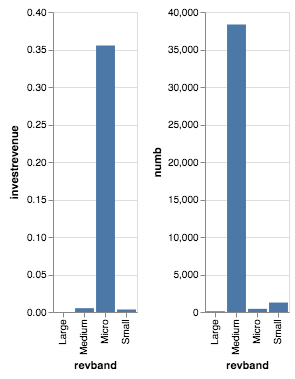

In [15]:
import altair as alt

bars = alt.Chart(investrevenue_summary_by_revenue).mark_bar().encode(
    y = 'investrevenue:Q',
    x = 'revband:N')

numbbars = alt.Chart(numb_summary_by_revenue).mark_bar().encode(
    y = 'numb:Q',
    x = 'revband:N')

bars | numbbars

# Evaluate the statement: *Medium sized companies spend less on cyber security because they have fewer breaches.*

This statement does not match what we observe in the data for several reasons. First of all, it appears that medium sized
companies spend relatively more on cybersecurity investment than all other categories, except for Micro. It seems reasonable
that Micro companies in this data would spend a lot more on cybersecurity, because many of them likely spend nothing
and we have eliminated all the companies which didn’t have a response to this question. Those Micro companies which
do spend on cybersecurity will have much higher fixed costs than a larger company, because hiring security employees or
paying for security tools are significant expenses for a company with under $10M in revenue.

Some potential challenges in evaluating this claim are:

* What counts as security spending? Some companies may consider various parts of their IT
budget to count toward security, whereas others might only include employees and tools who are strictly working on
security.
* What counts as a security breach? This seems like it could be open to many different interpretations depending on who is answering, and the pdf does not go into much detail on this question.
* Companies which spend nothing on cybersecurity - while some companies replied that they spend nothing, it could give some insight to examine what proportion of each tier answered -1 to investn, as many of these companies might spend nothing. In addition, some companies might report that they spend nothing because of differences in accounting for it

# Outliers

Considering the lack of clarity over what is considered a security breach first, look for extreme values in `numb_df`, sorting by `numb`. 

Using the line `numb_df.sort_values(by=['numb'], ascending=False).head(20)`, we can see that there are 12 companies (serials 2091, 1862, 2502, 949, 3913, 2381, 1949, 344, 1010, 198, 690, 1176) which report over 10,000 security breaches per year. Over the 1154 rows in `numb_df`, these top 12 add an average of $(1000000+250000+125000+100000+33600+24516.67+24516.67+24516.67+20000+20000+13500+10000) \approx 1,645,650/1124 \approx 1464$ security breaches per company in the dataframe. 

On the other hand, the number of companies which report having 0 security breaches per year is `len(numb_df.loc[numb_df['numb'] == 0])` = 531.

Create a new df `ol_numb_df` which removes these 12 rows.

In [16]:
ol_numb_df = numb_df.loc[numb_df['serial'].isin((2091, 1862, 2502, 949, 3913, 1949, 344, 1010, 198, 690, 1176)) == False]

Next, look for outliers in `investrevenue_df`, sorting by `investrevenue`. With the line `investrevenue_df.sort_values(by=['investrevenue'], ascending=False).head(10)`, we find 5 rows (serials 387, 3826, 2876, 2085, 4082) which have an `investrevenue` value close to or above one. 

One company, serial 387, has only \$91 in sales but spends \$25,000 on cyber defense. Although such a value is technically possible if these companies are early stage startups, these ratios still skew the results and outweigh the other results.

Create a new df `ol_ir_df` which removes these 5 rows.

In [17]:
ol_ir_df = investrevenue_df.loc[investrevenue_df['serial'].isin((387, 3826, 2876, 2085, 4082)) == False]

Create and display new summary dfs `sum_ol_numb_df` and `sum_ol_ir_df`

In [18]:
sum_ol_numb_df = ol_numb_df.groupby(ol_numb_df['revband']).mean()
sum_ol_ir_df = ol_ir_df.groupby(ol_ir_df['revband']).mean()
sum_ol_numb_df,sum_ol_ir_df

(              serial        salesa   weight0        investn        numb
 revband                                                                
 Large    1877.000000  1.183000e+09  0.000010   13755.055000  106.000000
 Medium   2069.720000  8.479120e+08  0.000028  945687.035200   69.600000
 Micro    2230.252784  1.838113e+06  0.000811    6334.572071   71.034967
 Small    2261.793578  4.843021e+07  0.000179   61342.780826   33.765092,
               serial        salesa   weight0       investn          numb  \
 revband                                                                    
 Large    3152.000000  1.066000e+09  0.000000  2.751111e+04     12.000000   
 Medium   1852.263158  7.825795e+08  0.000029  1.515510e+06  54487.263158   
 Micro    2191.861350  1.813141e+06  0.000828  7.007244e+03    460.747656   
 Small    2223.027778  4.793549e+07  0.000189  1.050154e+05    142.157111   
 
          investrevenue  
 revband                 
 Large         0.000026  
 Medium        0.00

Create a new column `revband` as before since altair cannot use the index.

In [19]:
sum_ol_ir_df['revband'] = sum_ol_ir_df.index
sum_ol_numb_df['revband'] = sum_ol_numb_df.index

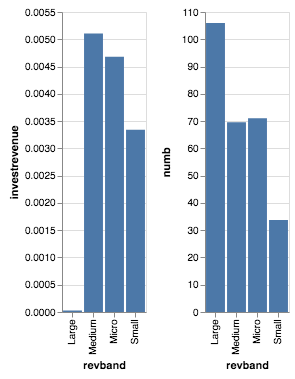

In [20]:
bars = alt.Chart(sum_ol_ir_df).mark_bar().encode(
    y = 'investrevenue:Q',
    x = 'revband:N')

numbbars = alt.Chart(sum_ol_numb_df).mark_bar().encode(
    y = 'numb:Q',
    x = 'revband:N')

bars | numbbars

As expected, the results look completely different by removing a relatively small proportion of the rows. The definitions of a security breach and security spending need to be very clear to survey participants in order for data like this have more meaning.

Just out of curiosity, how many `-1` values in `investn` per `revband` in `usd_combined_df`?

In [21]:
count_revband = usd_combined_df['serial'].groupby(usd_combined_df['revband']).count()
investn_minusone = usd_combined_df.loc[usd_combined_df['investn']==-1]
count_minusone_revband = investn_minusone['serial'].groupby(investn_minusone['revband']).count()
count_minusone_revband/count_revband

revband
Large     0.500000
Medium    0.366667
Micro     0.114471
Small     0.224138
Name: serial, dtype: float64